# References
- sklearn pipeline : https://www.kaggle.com/code/alexisbcook/pipelines
- ordinal categorical features : https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices

In [715]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from pandas.api.types import CategoricalDtype

from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from functools import reduce

from category_encoders import MEstimateEncoder, cat_boost

from sklearn.compose import ColumnTransformer

# Load data

In [716]:
# Read the data
X = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
X_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
#handling categorical variables is done later

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

print(X.shape)
print(X_test.shape)

print("Loaded data")

(1460, 79)
(1459, 79)
Loaded data


# Visualize target values

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


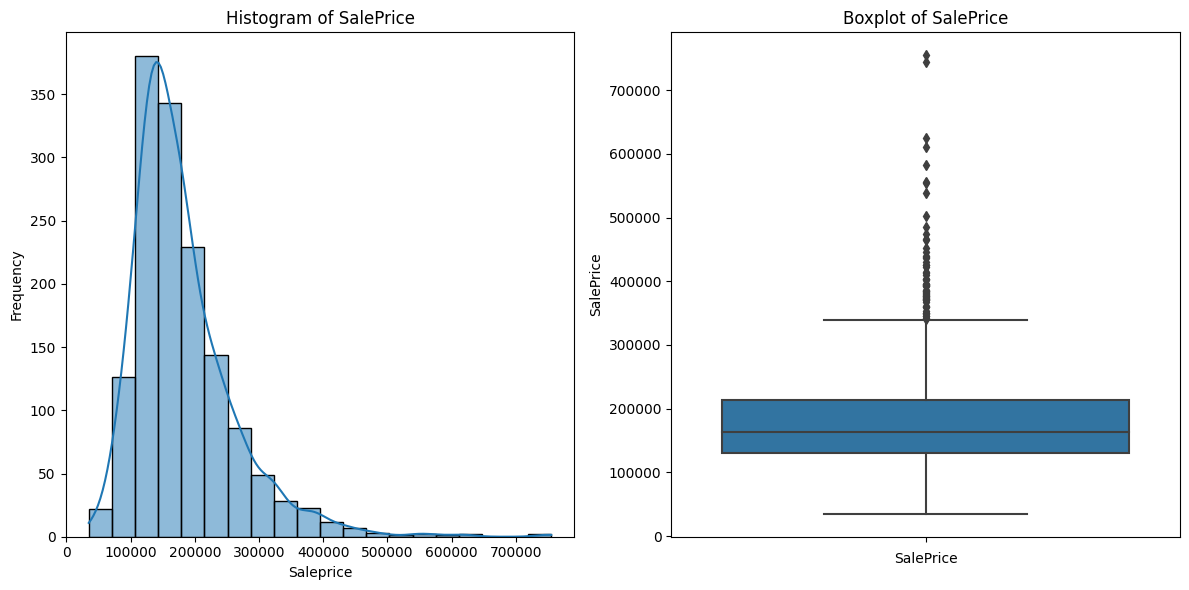

In [717]:
print(y.describe())

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(y, bins=20, kde=True, ax=axes[0])
axes[0].set_title("Histogram of SalePrice")
axes[0].set_xlabel("Saleprice")
axes[0].set_ylabel("Frequency")

sns.boxplot(y=y, ax=axes[1])
axes[1].set_title("Boxplot of SalePrice")
axes[1].set_xlabel("SalePrice")

plt.tight_layout()
plt.show()

Some Saleprice values seem really high. Lets check those.

In [718]:
y[y > 600000]

Id
692     755000
899     611657
1170    625000
1183    745000
Name: SalePrice, dtype: int64

We'll come back to this after determining some important features

# Explore and visualize date columns

There are date columns YrSold, MoSold, YearBuilt, YearRemodAdd, GarageYrBlt.
We'll have to check if there is difference between the values of these quantities b/w train and test data.

Particularly, difference YrSold b/w train and test might suggest ways to generate a validation dataset for model training.

In [719]:
X_copy = X.copy() 
X_test_copy = X_test.copy() 
X_copy["Dataset"] = "Train"
X_test_copy["Dataset"] = "Test"
plot_data = pd.concat([X_copy, X_test_copy])
print(plot_data.shape)
plot_data.loc[:, ["YrSold", "MoSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt"]].describe()

(2919, 80)


,YrSold,MoSold,YearBuilt,YearRemodAdd,GarageYrBlt
count,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000
mean,2007.792737,6.213087,1971.312778,1984.264474,1978.113406
std,1.314964,2.714762,30.291442,20.894344,25.574285
min,2006.000000,1.000000,1872.000000,1950.000000,1895.000000
25%,2007.000000,4.000000,1953.500000,1965.000000,1960.000000
50%,2008.000000,6.000000,1973.000000,1993.000000,1979.000000
75%,2009.000000,8.000000,2001.000000,2004.000000,2002.000000
max,2010.000000,12.000000,2010.000000,2010.000000,2207.000000


There seems to be lot of missing values for GarageYrBlt (2760 count out of 2919 rows). Are they all cases where there is no garage ?

In [720]:
sum(plot_data.GarageType.value_counts())

2762

2 houses with garages don't have garage-year-built. We'll consider this as a special imputation later and replace them with YearRemodAdd

In [721]:
X.loc[X.GarageYrBlt.isna() & X.GarageType.notna(), ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "GarageType"]]

,YearBuilt,YearRemodAdd,GarageYrBlt,GarageType
Id,,,,


In [722]:
X_test.loc[X_test.GarageYrBlt.isna() & X_test.GarageType.notna(), ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "GarageType"]]

,YearBuilt,YearRemodAdd,GarageYrBlt,GarageType
Id,,,,
2127,1910,1983,NaN,Detchd
2577,1923,1999,NaN,Detchd


In [723]:
X_test.loc[X_test.GarageYrBlt.isna() & X_test.GarageType.notna(), "GarageYrBlt"] = X_test.YearRemodAdd
X_test.loc[[2127, 2577], ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "GarageType"]]

,YearBuilt,YearRemodAdd,GarageYrBlt,GarageType
Id,,,,
2127,1910,1983,1983.0,Detchd
2577,1923,1999,1999.0,Detchd


In [724]:
def compare_dates(plot_data, column_name, column_descriptor, bin_num=10):

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    sns.histplot(data=plot_data, x=column_name, hue='Dataset', kde=False, bins=bin_num, palette='Set2', multiple='dodge', ax=axes[0])
    axes[0].set_title(f'Distribution of {column_descriptor} in Train and Test')
    axes[0].set_xlabel(column_descriptor)
    axes[0].set_ylabel('Frequency')

    sns.kdeplot(data=plot_data, x=column_name, hue='Dataset', fill=True, common_norm=False, alpha=0.5, palette='Set2', ax=axes[1])
    axes[1].set_title(f'Density Plot of {column_descriptor} in Train and Test')
    axes[1].set_xlabel(column_descriptor)
    axes[1].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

In [725]:
plot_data[["YrSold", "MoSold"]].describe()

,YrSold,MoSold
count,2919.000000,2919.000000
mean,2007.792737,6.213087
std,1.314964,2.714762
min,2006.000000,1.000000
25%,2007.000000,4.000000
50%,2008.000000,6.000000
75%,2009.000000,8.000000
max,2010.000000,12.000000


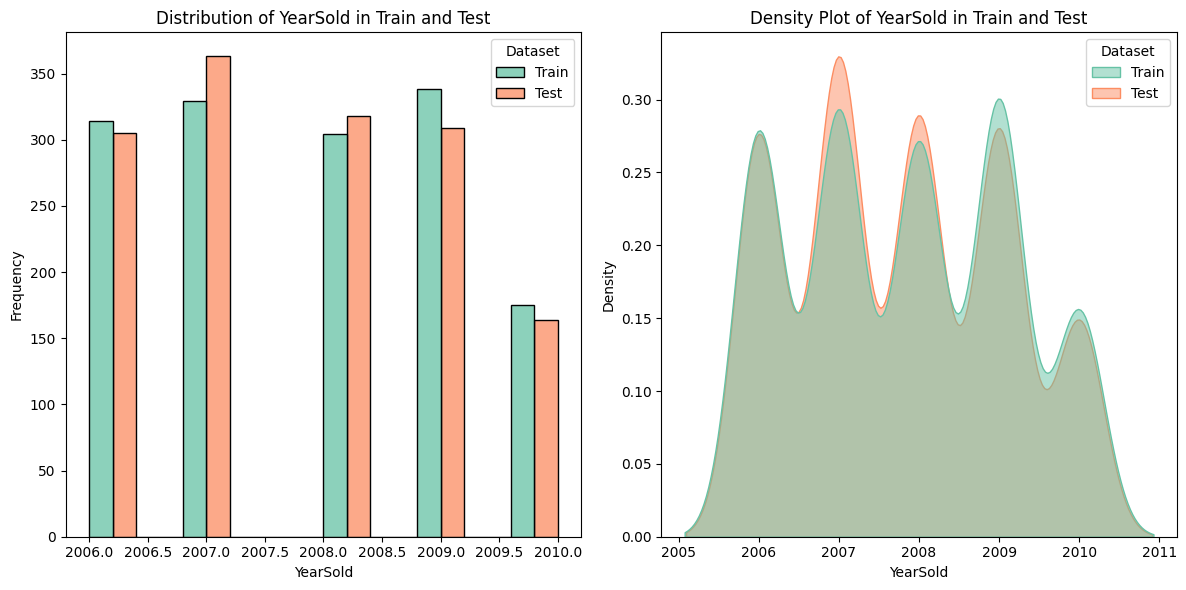

In [726]:
compare_dates(plot_data, 'YrSold', 'YearSold', bin_num=10)

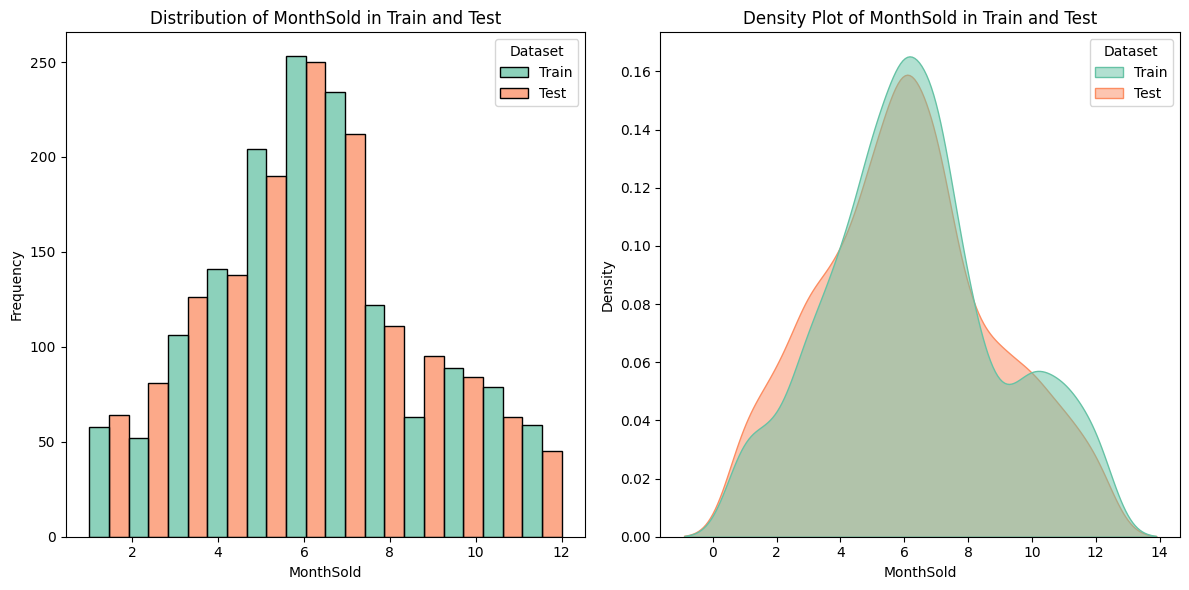

In [727]:
compare_dates(plot_data, 'MoSold', 'MonthSold', bin_num=12)

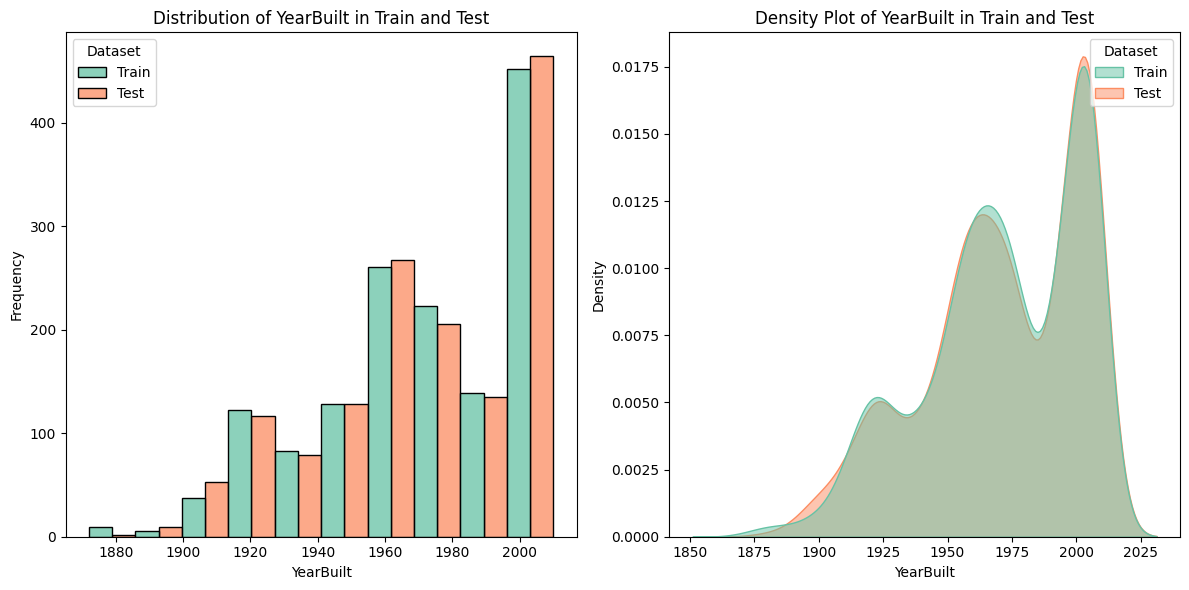

In [728]:
compare_dates(plot_data, 'YearBuilt', 'YearBuilt', bin_num=10)

In [729]:
plot_data.YearRemodAdd.describe()

count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

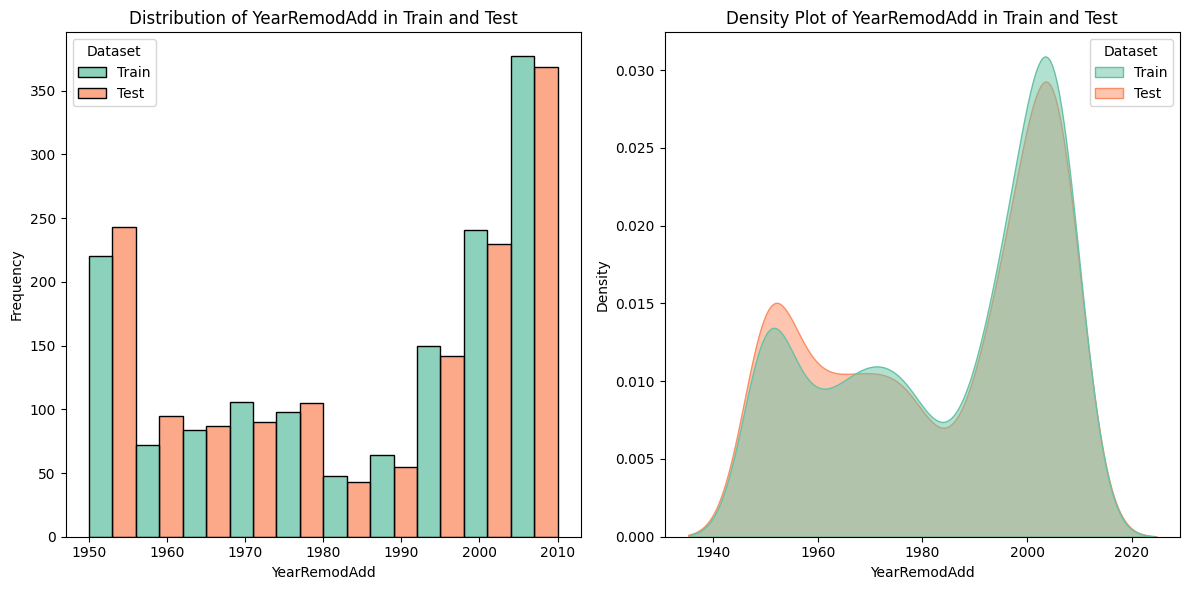

In [730]:
compare_dates(plot_data, 'YearRemodAdd', 'YearRemodAdd', bin_num=10)

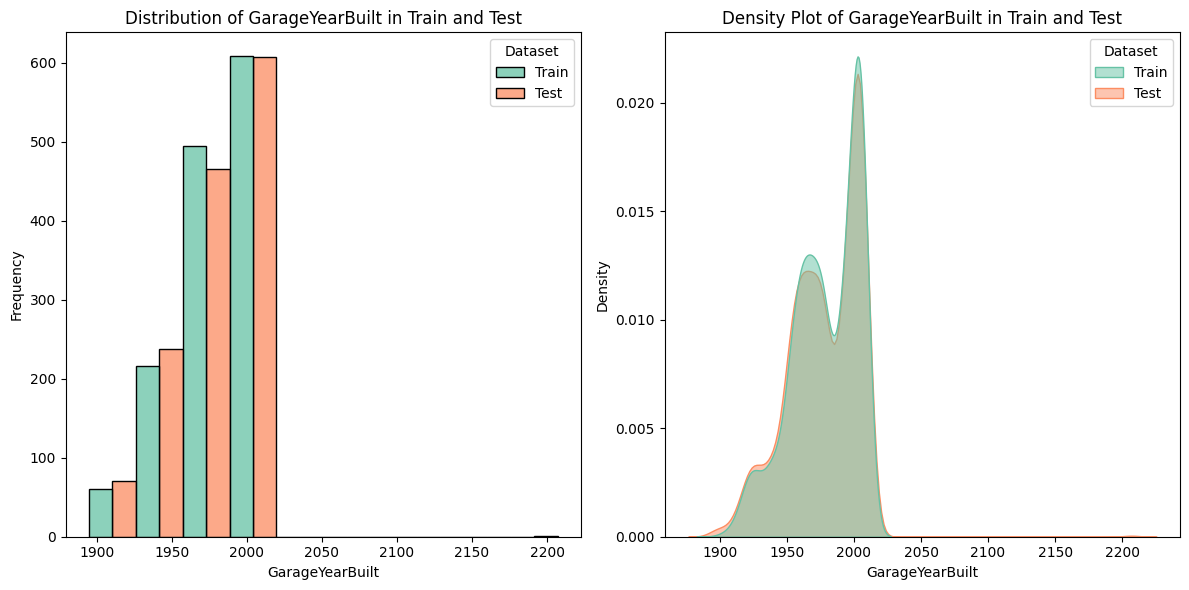

In [731]:
compare_dates(plot_data, 'GarageYrBlt', 'GarageYearBuilt', bin_num=10)

Some of the test data GarageYrBlt is 2200 ! That needs to be checked.

In [732]:
print(X.GarageYrBlt.describe())

print(X_test.GarageYrBlt.describe())

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
count    1383.000000
mean     1977.740419
std        26.418619
min      1895.000000
25%      1959.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


In [733]:
#Why 2008 ? 2010 gave only 1 row i.e. the row with outlier value.
# 2005 gave too many rows. Just want to see values of few other similar rows.
# So 2008
X_test.loc[X_test.GarageYrBlt > 2008, ["YrSold", "MoSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt", "GarageType", 
                                       "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond"]]

,YrSold,MoSold,YearBuilt,YearRemodAdd,GarageYrBlt,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
Id,,,,,,,,,,,
1476,2010,1,2009,2010,2009.0,Attchd,Fin,3.0,751.0,TA,TA
1477,2010,6,2009,2010,2009.0,Attchd,RFn,3.0,868.0,TA,TA
1489,2010,4,2009,2010,2009.0,Attchd,RFn,2.0,676.0,TA,TA
1503,2010,4,2010,2010,2010.0,Attchd,RFn,3.0,852.0,TA,TA
1573,2010,1,2009,2010,2009.0,Attchd,RFn,2.0,572.0,TA,TA
1577,2010,3,2010,2010,2009.0,Attchd,RFn,2.0,615.0,TA,TA
1609,2010,1,2009,2010,2010.0,Attchd,RFn,2.0,520.0,TA,TA
1662,2009,7,2009,2009,2009.0,Attchd,RFn,3.0,864.0,TA,TA
1712,2009,10,2008,2009,2009.0,Attchd,Fin,2.0,517.0,TA,TA


The 2207 seems to be a typo of YearRemodAdd - 2007

In [734]:
X_test["GarageYrBlt"] = X_test["GarageYrBlt"].where(X_test.GarageYrBlt <= 2024, X_test.YearRemodAdd)

X_test.loc[2593, "GarageYrBlt"]

2007.0

(2919, 80)
            YrSold       MoSold    YearBuilt  YearRemodAdd  GarageYrBlt
count  2919.000000  2919.000000  2919.000000   2919.000000  2838.000000
mean   2007.792737     6.213087  1971.312778   1984.264474  1977.923890
std       1.314964     2.714762    30.291442     20.894344    25.164076
min    2006.000000     1.000000  1872.000000   1950.000000  1895.000000
25%    2007.000000     4.000000  1953.500000   1965.000000  1960.000000
50%    2008.000000     6.000000  1973.000000   1993.000000  1979.000000
75%    2009.000000     8.000000  2001.000000   2004.000000  2002.000000
max    2010.000000    12.000000  2010.000000   2010.000000  2010.000000


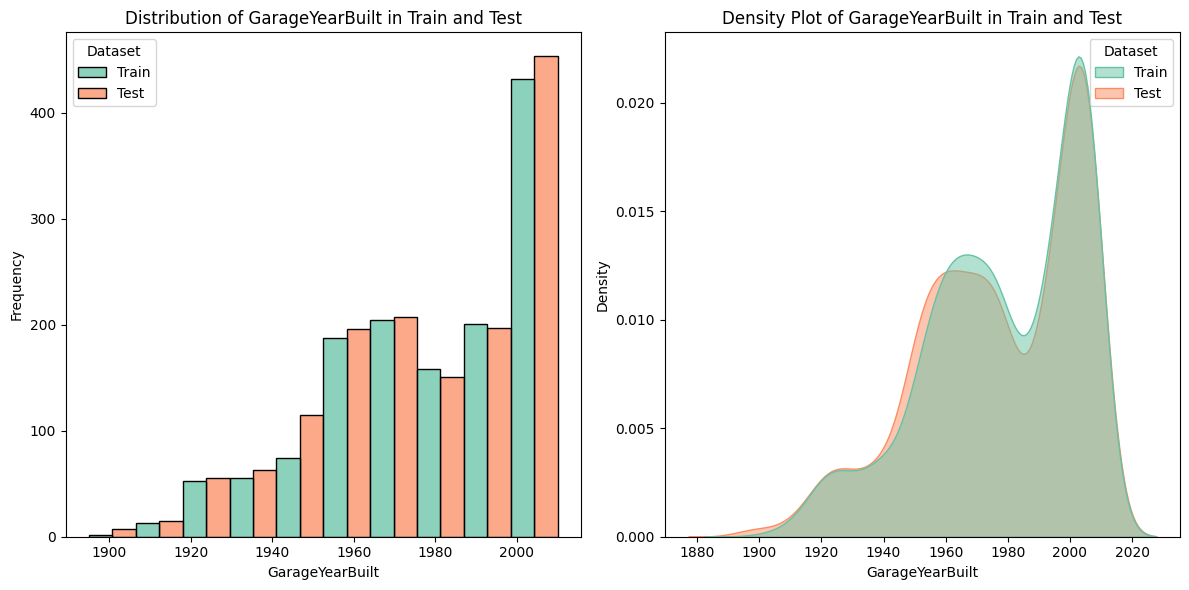

In [735]:
X_copy = X.copy() 
X_test_copy = X_test.copy() 
X_copy["Dataset"] = "Train"
X_test_copy["Dataset"] = "Test"
plot_data = pd.concat([X_copy, X_test_copy])
print(plot_data.shape)
print(plot_data.loc[:, ["YrSold", "MoSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt"]].describe())
compare_dates(plot_data, 'GarageYrBlt', 'GarageYearBuilt', bin_num=10)

Regarding the data distribution, based on the plots above, all the date columns have same distribution in train and test.

# Other data clean

In [736]:
# checking if Exterior2nd values need to be modified as specified in https://www.kaggle.com/code/abhivij/feature-engineering-for-house-prices
print(X.Exterior2nd.unique())
print(X_test.Exterior2nd.unique())

print(X.Exterior1st.unique())
print(X_test.Exterior1st.unique())

['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'Brk Cmn' 'CmentBd'
 'ImStucc' 'Wd Shng' 'AsbShng' 'Stucco' 'CBlock' 'BrkFace' 'AsphShn' nan
 'Stone']
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'CemntBd' 'WdShing'
 'BrkFace' 'AsbShng' 'BrkComm' 'Stucco' 'AsphShn' nan 'CBlock']


In [737]:
X["Exterior2nd"] = X["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
X_test["Exterior2nd"] = X_test["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
print(X.Exterior2nd.unique())
print(X_test.Exterior2nd.unique())

['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'BrkComm' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'BrkComm' 'CmentBd'
 'ImStucc' 'Wd Shng' 'AsbShng' 'Stucco' 'CBlock' 'BrkFace' 'AsphShn' nan
 'Stone']


# Categorical features - special handling
Ref : https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices

In [738]:
# X.OverallQual.unique()
# # array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

# X.OverallCond.unique()
# # array([5, 8, 6, 7, 4, 2, 3, 9, 1])

In [739]:
# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", 
                "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1, 11))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}
ordered_levels.keys()

dict_keys(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'LotShape', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Utilities', 'CentralAir', 'Electrical', 'Fence'])

In [740]:
def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [741]:
X = encode(X)
X_test = encode(X_test)

In [742]:
def missing_info(df):
    missing_count_df = pd.DataFrame(df.isna().sum(), columns = ["missing_count"]).sort_values(by = "missing_count", ascending = False)
    missing_count_df["missing_percentage"] = missing_count_df.missing_count * 100.0 / df.shape[0]
    return missing_count_df

In [743]:
missing_info(X).iloc[:10, :]

,missing_count,missing_percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945


In [744]:
missing_info(X_test).iloc[:10, :]

,missing_count,missing_percentage
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
MasVnrType,894,61.274846
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageFinish,78,5.346127
GarageQual,78,5.346127
GarageCond,78,5.346127


For now, lets impute all missing values. 

And then check feature importance score to see if least scores are for max missing val columns and then decide which columns to drop.

In [745]:
def impute(df):
    df.loc[df.GarageYrBlt.isna() & df.GarageType.notna(), "GarageYrBlt"] = df.YearRemodAdd
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

# Function to load and preprocess data

In [746]:
# we might need to keep testing different steps of preprocessing and adding new features
# obatining a fresh copy of the data after preprocessing will be helpful for this purpose

# create a function to perform data load and preprocessing together
def load_and_preprocess_data(train_data = True, perform_impute = True):
    if train_data:
        print("Train data")
        X = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
        X.dropna(axis=0, subset=['SalePrice'], inplace=True)
        y = X.SalePrice
        X.drop(['SalePrice'], axis=1, inplace=True)
    else:
        print("Test data")
        X = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
        y = None
    print("Loaded data")
    print(X.shape)

    X["GarageYrBlt"] = X["GarageYrBlt"].where((X.GarageYrBlt.isna() | (X.GarageYrBlt <= 2024)), X.YearRemodAdd)  #there is 1 GarageYrBlt with value 2207
    X["Exterior2nd"] = X["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    X = encode(X)
    if perform_impute:
        X = impute(X)
    
    return (X, y)

In [747]:
X, y = load_and_preprocess_data()
display(X)

X_test, _ = load_and_preprocess_data(train_data = False)
display(X_test)

Train data
Loaded data
(1460, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal


Test data
Loaded data
(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,144,0,None,None,None,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2006,WD,Abnorml


# Scoring function

In [748]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    X = X.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_root_mean_squared_error",
    )
    score = -1 * score.mean()
    return score

In [749]:
#baseline score
# score_dataset(X, y)
# # 0.1407102329971716

# Feature Utility Scores

In [750]:
def make_mi_scores(X, y):
    X = X.copy(deep = True)
    for name in X.select_dtypes("number"):
        X[name] = X[name].fillna(0)
    for name in X.select_dtypes("category"):
        X[name] = X[name].fillna("None")
        
    for name in X.select_dtypes(["category"]):
        X[name] = X[name].cat.codes
        
    # All discrete features should now have integer dtypes
    # discrete features are features that are not floats
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [751]:
mi_scores = pd.DataFrame(make_mi_scores(X, y))
mi_scores

,MI Scores
OverallQual,5.786503e-01
Neighborhood,5.253900e-01
GarageArea,4.927946e-01
GrLivArea,4.328080e-01
YearBuilt,4.087151e-01
...,...
Utilities,1.887379e-15
PoolArea,2.220446e-16
PoolQC,0.000000e+00
MiscVal,0.000000e+00


In [752]:
mi_scores[:20], mi_scores[-20:]

(              MI Scores
 OverallQual    0.578650
 Neighborhood   0.525390
 GarageArea     0.492795
 GrLivArea      0.432808
 YearBuilt      0.408715
 TotalBsmtSF    0.399518
 LotArea        0.392427
 GarageCars     0.360102
 BsmtQual       0.331398
 ExterQual      0.325150
 KitchenQual    0.322472
 1stFlrSF       0.283265
 MSSubClass     0.278183
 YearRemodAdd   0.275659
 FullBath       0.273156
 GarageFinish   0.262945
 GarageYrBlt    0.260881
 LotFrontage    0.216092
 FireplaceQu    0.209348
 TotRmsAbvGrd   0.207962,
                  MI Scores
 ExterCond     1.845965e-02
 LotConfig     1.593551e-02
 BsmtFullBath  1.318343e-02
 Heating       1.287198e-02
 BsmtHalfBath  1.131273e-02
 Functional    1.084641e-02
 LowQualFinSF  6.635548e-03
 RoofMatl      4.894636e-03
 LandSlope     4.280622e-03
 YrSold        3.618707e-03
 BsmtFinSF2    2.734002e-03
 MiscFeature   2.703237e-03
 Condition2    2.664787e-03
 3SsnPorch     7.615664e-04
 Street        3.666896e-04
 Utilities     1.887379e-1

In [753]:
X.MiscVal.describe()

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

MiscVal seems to be mostly all 0s.

Top missing value columns were : PoolQC(99,99), MiscFeature(96,96), Alley(93,92), Fence(80,80), MasVnrType(59,61), FireplceQu(47,50)

In [754]:
mi_scores["Id"] = range(0, mi_scores.shape[0])
mi_scores

,MI Scores,Id
OverallQual,5.786503e-01,0
Neighborhood,5.253900e-01,1
GarageArea,4.927946e-01,2
GrLivArea,4.328080e-01,3
YearBuilt,4.087151e-01,4
...,...,...
Utilities,1.887379e-15,74
PoolArea,2.220446e-16,75
PoolQC,0.000000e+00,76
MiscVal,0.000000e+00,77


In [755]:
mi_scores.loc[["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType", "FireplaceQu"], :]

,MI Scores,Id
PoolQC,0.000000,76
MiscFeature,0.002703,70
Alley,0.026424,54
Fence,0.045973,48
MasVnrType,0.096800,34
FireplaceQu,0.209348,18


PoolQC, MiscVal, MoSold, PoolArea, MiscFeature, Utilities can be deleted.

MasVnrType, FireplaceQu should be retained since they have quite high MI Scores.

Alley, Fence need to be explored more.

Fence, Electrical from the category names seem to be better if unordered, since all the categories do not seem to be follow a natural ordering.

In [756]:
del ordered_levels["Fence"], ordered_levels["Electrical"]
print(ordered_levels.keys())

features_nom = features_nom + ["Fence", "Electrical"]
print(features_nom)

dict_keys(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'LotShape', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'PavedDrive', 'Utilities', 'CentralAir'])
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 'Fence', 'Electrical']


In [757]:
X, y = load_and_preprocess_data()
X_test, _ = load_and_preprocess_data(train_data = False)

mi_scores = pd.DataFrame(make_mi_scores(X, y))
mi_scores["Id"] = range(0, mi_scores.shape[0])
mi_scores.loc[["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType", "FireplaceQu", "Electrical"], :]

Train data
Loaded data
(1460, 79)
Test data
Loaded data
(1459, 79)


,MI Scores,Id
PoolQC,0.000000,76
MiscFeature,0.002703,70
Alley,0.026424,54
Fence,0.045973,48
MasVnrType,0.096800,34
FireplaceQu,0.209348,18
Electrical,0.044690,49


In [758]:
X.Alley.value_counts(), X_test.Alley.value_counts()

(Alley
 None    1369
 Grvl      50
 Pave      41
 Name: count, dtype: int64,
 Alley
 None    1352
 Grvl      70
 Pave      37
 Name: count, dtype: int64)

In [759]:
X.Fence.value_counts(), X_test.Fence.value_counts()

(Fence
 None     1179
 MnPrv     157
 GdPrv      59
 GdWo       54
 MnWw       11
 Name: count, dtype: int64,
 Fence
 None     1169
 MnPrv     172
 GdPrv      59
 GdWo       58
 MnWw        1
 Name: count, dtype: int64)

In [760]:
X, y = load_and_preprocess_data(perform_impute = False)
X_test, _ = load_and_preprocess_data(train_data = False, perform_impute = False)
print(X.Alley.value_counts(), X_test.Alley.value_counts(), X.Fence.value_counts(), X_test.Fence.value_counts())
X, y = load_and_preprocess_data()
X_test, _ = load_and_preprocess_data(train_data = False)

Train data
Loaded data
(1460, 79)
Test data
Loaded data
(1459, 79)
Alley
Grvl    50
Pave    41
None     0
Name: count, dtype: int64 Alley
Grvl    70
Pave    37
None     0
Name: count, dtype: int64 Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
None       0
Name: count, dtype: int64 Fence
MnPrv    172
GdPrv     59
GdWo      58
MnWw       1
None       0
Name: count, dtype: int64
Train data
Loaded data
(1460, 79)
Test data
Loaded data
(1459, 79)


There are previously no 'None' values. All missing values were converted to 'None' during imputation

Alley
Grvl    119500.0
Pave    172500.0
None    165000.0
Name: SalePrice, dtype: float64
Fence
GdPrv    167500.0
GdWo     138750.0
MnPrv    137450.0
MnWw     130000.0
None     173000.0
Name: SalePrice, dtype: float64


<ipython-input-761-41fd3a7aa5ee>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X_copy.groupby("Alley")["SalePrice"].median())
<ipython-input-761-41fd3a7aa5ee>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X_copy.groupby("Fence")["SalePrice"].median())
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/us

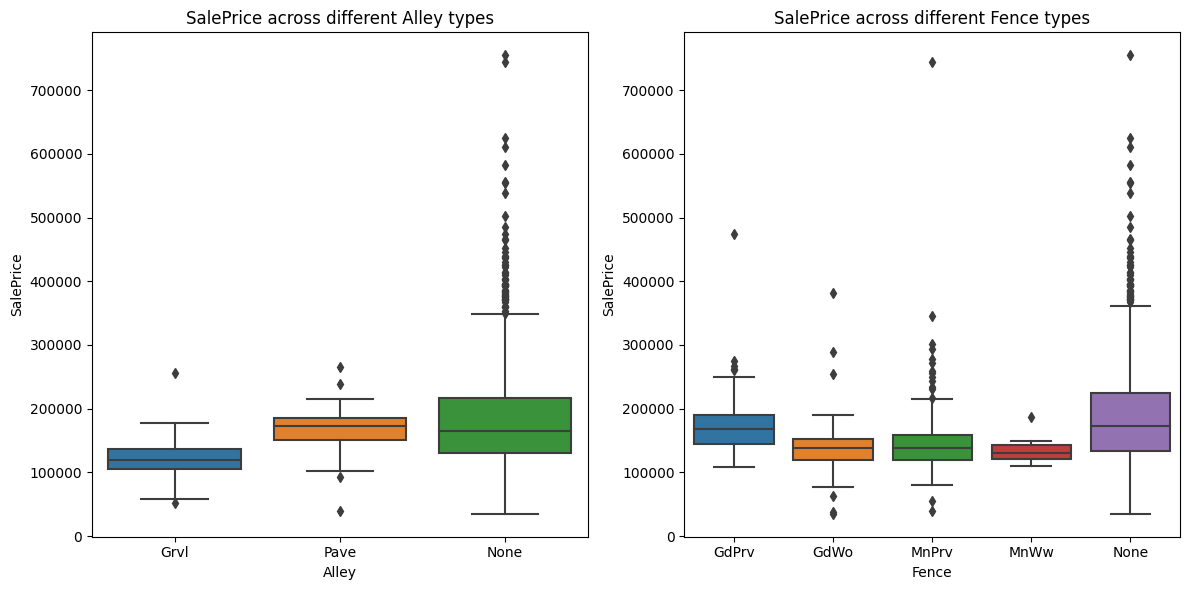

In [761]:
X_copy = X.copy()
X_copy["SalePrice"] = y
print(X_copy.groupby("Alley")["SalePrice"].median())
print(X_copy.groupby("Fence")["SalePrice"].median())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x = "Alley", y = "SalePrice", data = X_copy, ax=axes[0])
axes[0].set_title("SalePrice across different Alley types")
axes[0].set_xlabel("Alley")
axes[0].set_ylabel("SalePrice")

sns.boxplot(x = "Fence", y = "SalePrice", data = X_copy, ax=axes[1])
axes[1].set_title("SalePrice across different Fence types")
axes[1].set_xlabel("Fence")
axes[1].set_ylabel("SalePrice")

plt.tight_layout()
plt.show()

There does seem to be some visible variation in SalePrice across the Alley and Fence categories. Lets retain Alley, Fence.

So columns to delete are PoolQC, MiscVal, MoSold, PoolArea, MiscFeature, Utilities.

Before removing MoSold, it would be worthwhile to check if combining YrSold and MoSold gives some useful feature.

In [762]:
X['SoldDate'] = pd.to_datetime(X['YrSold'].astype(str) + '-' + X['MoSold'].astype(str) + '-01')

# Compute time difference from January 1, 1800, in months
reference_date = pd.Timestamp('1800-01-01')
X['MonthsSince1800'] = ((X['SoldDate'].dt.year - reference_date.year) * 12 +
                         (X['SoldDate'].dt.month - reference_date.month))

X['YearsSince1800'] = X['SoldDate'].dt.year - reference_date.year

In [763]:
mi_scores = pd.DataFrame(make_mi_scores(X.drop(columns="SoldDate"), y))
mi_scores

,MI Scores
OverallQual,5.786503e-01
Neighborhood,5.253900e-01
GarageArea,4.927946e-01
GrLivArea,4.328080e-01
YearBuilt,4.087151e-01
...,...
PoolArea,2.220446e-16
MiscVal,0.000000e+00
MoSold,0.000000e+00
MonthsSince1800,0.000000e+00


In [764]:
mi_scores[:20], mi_scores[-20:]

(              MI Scores
 OverallQual    0.578650
 Neighborhood   0.525390
 GarageArea     0.492795
 GrLivArea      0.432808
 YearBuilt      0.408715
 TotalBsmtSF    0.399518
 LotArea        0.392427
 GarageCars     0.360102
 BsmtQual       0.331398
 ExterQual      0.325150
 KitchenQual    0.322472
 1stFlrSF       0.283265
 MSSubClass     0.278183
 YearRemodAdd   0.275659
 FullBath       0.273156
 GarageFinish   0.262945
 GarageYrBlt    0.260881
 LotFrontage    0.216092
 FireplaceQu    0.209348
 TotRmsAbvGrd   0.207962,
                     MI Scores
 BsmtFullBath     1.318343e-02
 Heating          1.287198e-02
 BsmtHalfBath     1.131273e-02
 Functional       1.084641e-02
 LowQualFinSF     6.635548e-03
 RoofMatl         4.894636e-03
 LandSlope        4.280622e-03
 YrSold           3.618707e-03
 YearsSince1800   3.618707e-03
 BsmtFinSF2       2.734002e-03
 MiscFeature      2.703237e-03
 Condition2       2.664787e-03
 3SsnPorch        7.615664e-04
 Street           3.666896e-04
 Utilitie

MonthsSince1800 does not seem to add any value. 
YearsSince1800 has the same MI score as YrSold. So the process of year difference used for 'Since1800' columns is correct.

In [765]:
missing_info(X).loc[["PoolArea", "MiscVal", "MoSold", "Utilities"], :], missing_info(X_test).loc[["PoolArea", "MiscVal", "MoSold", "Utilities"], :]

(           missing_count  missing_percentage
 PoolArea               0                 0.0
 MiscVal                0                 0.0
 MoSold                 0                 0.0
 Utilities              0                 0.0,
            missing_count  missing_percentage
 PoolArea               0                 0.0
 MiscVal                0                 0.0
 MoSold                 0                 0.0
 Utilities              0                 0.0)

In [766]:
X, y = load_and_preprocess_data(perform_impute = False)
X_test, _ = load_and_preprocess_data(train_data = False, perform_impute = False)
missing_info(X).loc[["PoolArea", "MiscVal", "MoSold", "Utilities"], :], missing_info(X_test).loc[["PoolArea", "MiscVal", "MoSold", "Utilities"], :]

Train data
Loaded data
(1460, 79)
Test data
Loaded data
(1459, 79)


(           missing_count  missing_percentage
 PoolArea               0                 0.0
 MiscVal                0                 0.0
 MoSold                 0                 0.0
 Utilities              0                 0.0,
            missing_count  missing_percentage
 PoolArea               0             0.00000
 MiscVal                0             0.00000
 MoSold                 0             0.00000
 Utilities              2             0.13708)

In [767]:
X[["PoolArea", "MiscVal", "MoSold", "Utilities"]].describe()

,PoolArea,MiscVal,MoSold
count,1460.000000,1460.000000,1460.000000
mean,2.758904,43.489041,6.321918
std,40.177307,496.123024,2.703626
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,5.000000
50%,0.000000,0.000000,6.000000
75%,0.000000,0.000000,8.000000
max,738.000000,15500.000000,12.000000


PoolArea, MiscVal seem to be mostly 0s

In [768]:
X.Utilities.value_counts(), X_test.Utilities.value_counts()

(Utilities
 AllPub    1459
 NoSeWa       1
 None         0
 ELO          0
 NoSewr       0
 Name: count, dtype: int64,
 Utilities
 AllPub    1457
 None         0
 ELO          0
 NoSeWa       0
 NoSewr       0
 Name: count, dtype: int64)

All except 1 row have AllPub. Explains why Utility has low MI score.
There's just 1 Utility with value NoSeWa. Lets check the corresponding data.

In [769]:
X[X.Utilities == "NoSeWa"], y[X.Utilities == "NoSeWa"]

(    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 Id                                                                    
 945         20       RL          NaN    14375   Pave   NaN      IR1   
 
     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
 Id                                   ...                                     
 945         Lvl    NoSeWa   CulDSac  ...         233        0    NaN   NaN   
 
     MiscFeature MiscVal MoSold YrSold  SaleType  SaleCondition  
 Id                                                              
 945         NaN       0      1   2009       COD        Abnorml  
 
 [1 rows x 79 columns],
 Id
 945    137500
 Name: SalePrice, dtype: int64)

This data row looks okay.

y value is in b/w 25 quantile and 50 quantile, so looks okay too.

No reason to remove this row.

In [770]:
X, y = load_and_preprocess_data()
X_test, _ = load_and_preprocess_data(train_data = False)
# features_to_drop = ['MoSold', 'MiscVal', 'Utilities']     initially removed columns  
features_to_drop = ['PoolQC', 'MiscVal', 'MoSold', 'PoolArea', 'MiscFeature', 'Utilities']
X.drop(columns = features_to_drop, inplace = True)
X_test.drop(columns = features_to_drop, inplace = True)
print(X.shape)
print(X_test.shape)

score_dataset(X, y)
# 0.1380548299562236

Train data
Loaded data
(1460, 79)
Test data
Loaded data
(1459, 79)
(1460, 73)
(1459, 73)


0.1380548299562236

That gives a some increase in performance

Coming back to rows with high y-values

In [795]:
y[y>600000]

Id
692     755000
899     611657
1170    625000
1183    745000
Name: SalePrice, dtype: int64

Lets analyse columns with high MI scores and few other useful sounding columns

In [789]:
# High MI scores
#   OverallQual    0.578650
#   Neighborhood   0.525390
#   GarageArea     0.492795
#   GrLivArea      0.432808
#   YearBuilt      0.408715
#   TotalBsmtSF    0.399518
#   LotArea        0.392427
#   GarageCars     0.360102

X_copy = X.copy()
X_copy["SalePrice"] = y
X_copy.loc[y > 600000, ["SalePrice", "MSSubClass", "BldgType", "HouseStyle",
                    "YearBuilt", "YearRemodAdd", "YrSold", 
                    "LotArea", "GrLivArea", "TotalBsmtSF", "OverallQual", "OverallCond",
                    "GarageArea", "GarageCars",
                    "Neighborhood", "SaleType", "SaleCondition"]]

,SalePrice,MSSubClass,BldgType,HouseStyle,YearBuilt,YearRemodAdd,YrSold,LotArea,GrLivArea,TotalBsmtSF,OverallQual,OverallCond,GarageArea,GarageCars,Neighborhood,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,
692,755000,60,1Fam,2Story,1994,1995,2007,21535,4316,2444,10,6,832,3,NoRidge,WD,Normal
899,611657,20,1Fam,1Story,2009,2010,2010,12919,2364,2330,9,5,820,3,NridgHt,New,Partial
1170,625000,60,1Fam,2Story,1995,1996,2006,35760,3627,1930,10,5,807,3,NoRidge,WD,Normal
1183,745000,60,1Fam,2Story,1996,1996,2007,15623,4476,2396,10,5,813,3,NoRidge,WD,Abnorml


<ipython-input-783-ef87f5c7b14f>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X_copy.groupby("SaleType")["SalePrice"].median())
<ipython-input-783-ef87f5c7b14f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X_copy.groupby("SaleCondition")["SalePrice"].median())
<ipython-input-783-ef87f5c7b14f>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X_copy.groupby("Neighborhood")["SalePrice"].median())
/

SaleType
COD      139000.0
CWD      188750.0
Con      269600.0
ConLD    140000.0
ConLI    125000.0
ConLw    144000.0
New      247453.0
Oth      116050.0
WD       158000.0
None          NaN
Name: SalePrice, dtype: float64
SaleCondition
Abnorml    130000.0
AdjLand    104000.0
Alloca     148145.0
Family     140500.0
Normal     160000.0
Partial    244600.0
None            NaN
Name: SalePrice, dtype: float64
Neighborhood
Blmngtn    191000.0
Blueste    137500.0
BrDale     106000.0
BrkSide    124300.0
ClearCr    200250.0
CollgCr    197200.0
Crawfor    200624.0
Edwards    121750.0
Gilbert    181000.0
IDOTRR     103000.0
MeadowV     88000.0
Mitchel    153500.0
NAmes      140000.0
NPkVill    146000.0
NWAmes     182900.0
NoRidge    301500.0
NridgHt    315000.0
OldTown    119000.0
SWISU      139500.0
Sawyer     135000.0
SawyerW    179900.0
Somerst    225500.0
StoneBr    278000.0
Timber     228475.0
Veenker    218000.0
None            NaN
Name: SalePrice, dtype: float64


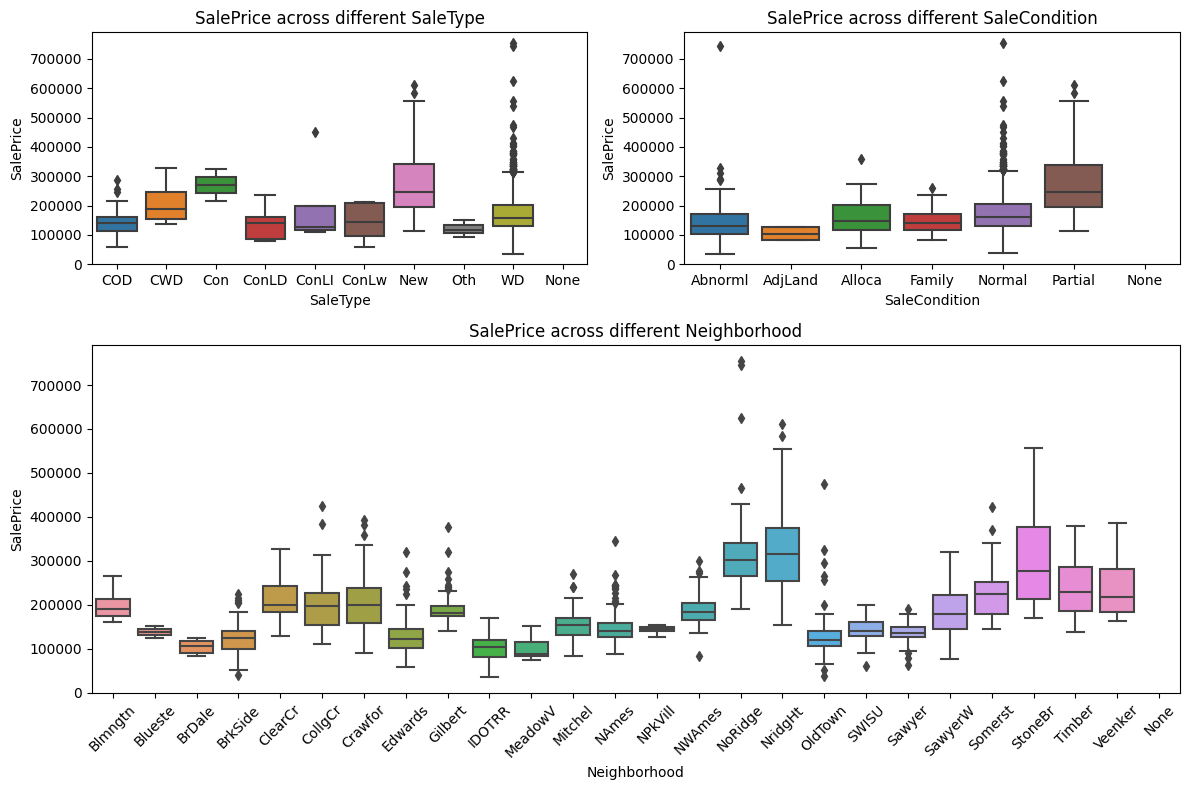

In [783]:
print(X_copy.groupby("SaleType")["SalePrice"].median())
print(X_copy.groupby("SaleCondition")["SalePrice"].median())
print(X_copy.groupby("Neighborhood")["SalePrice"].median())

# fig = plt.figure(figsize=(12, 8))
# grid = plt.GridSpec(2, 2, height_ratios=[1, 1.5])

# # Subplot 1
# ax1 = fig.add_subplot(grid[0, 0])
# sns.lineplot(data=data, x='x', y='y1', ax=ax1)
# ax1.set_title('Plot 1')

# # Subplot 2
# ax2 = fig.add_subplot(grid[0, 1])
# sns.barplot(data=data, x='x', y='y2', ax=ax2)
# ax2.set_title('Plot 2')

# # Subplot 3
# ax3 = fig.add_subplot(grid[1, :])

fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(2, 2, height_ratios=[1, 1.5])
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, :])

sns.boxplot(x = "SaleType", y = "SalePrice", data = X_copy, ax=ax1)
ax1.set_title("SalePrice across different SaleType")
ax1.set_xlabel("SaleType")
ax1.set_ylabel("SalePrice")

sns.boxplot(x = "SaleCondition", y = "SalePrice", data = X_copy, ax=ax2)
ax2.set_title("SalePrice across different SaleCondition")
ax2.set_xlabel("SaleCondition")
ax2.set_ylabel("SalePrice")

sns.boxplot(x = "Neighborhood", y = "SalePrice", data = X_copy, ax=ax3)
ax3.set_title("SalePrice across different Neighborhood")
ax3.set_xlabel("Neighborhood")
ax3.set_ylabel("SalePrice")
ax3.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

In [791]:
X_copy.loc[X.SaleCondition == "Abnorml", ["SalePrice", "MSSubClass", "BldgType", "HouseStyle",
                    "YearBuilt", "YearRemodAdd", "YrSold", 
                    "LotArea", "GrLivArea", "TotalBsmtSF", "OverallQual", "OverallCond",
                    "GarageArea", "GarageCars",
                    "Neighborhood", "SaleType", "SaleCondition"]].sort_values(by = "SalePrice", ascending = False)

,SalePrice,MSSubClass,BldgType,HouseStyle,YearBuilt,YearRemodAdd,YrSold,LotArea,GrLivArea,TotalBsmtSF,OverallQual,OverallCond,GarageArea,GarageCars,Neighborhood,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,
1183,745000,60,1Fam,2Story,1996,1996,2007,15623,4476,2396,10,5,813,3,NoRidge,WD,Abnorml
886,328900,120,TwnhsE,1Story,1999,2000,2008,5119,1709,1698,9,5,506,2,Somerst,CWD,Abnorml
1033,310000,60,1Fam,2Story,1993,1993,2006,14541,2520,1338,8,7,796,3,NoRidge,WD,Abnorml
227,290000,60,1Fam,2Story,1995,1995,2007,9950,2520,1203,7,5,721,3,NoRidge,WD,Abnorml
1025,287000,20,1Fam,1Story,1976,1976,2008,15498,2898,1565,8,6,665,2,Timber,COD,Abnorml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,66500,50,1Fam,1.5Fin,1941,1950,2009,5720,1131,676,5,6,200,1,OldTown,WD,Abnorml
411,60000,20,1Fam,1Story,1958,1958,2009,9571,1276,1276,5,3,350,1,Edwards,COD,Abnorml
969,37900,50,1Fam,1.5Fin,1910,1950,2009,5925,968,600,3,6,0,0,OldTown,WD,Abnorml


Though these rows seem to be outliers within different categories, they do have large values for LotArea, GrLivArea. We'll retain these rows.

HouseStyle and BldgType seems to be useful and have different categories. Lets check if all categories in test data is present in train.

In [796]:
X.BldgType.value_counts(), X_test.BldgType.value_counts()

(BldgType
 1Fam      1220
 TwnhsE     114
 Duplex      52
 Twnhs       43
 2fmCon      31
 None         0
 Name: count, dtype: int64,
 BldgType
 1Fam      1205
 TwnhsE     113
 Duplex      57
 Twnhs       53
 2fmCon      31
 None         0
 Name: count, dtype: int64)

In [797]:
X.HouseStyle.value_counts(), X_test.HouseStyle.value_counts()

(HouseStyle
 1Story    726
 2Story    445
 1.5Fin    154
 SLvl       65
 SFoyer     37
 1.5Unf     14
 2.5Unf     11
 2.5Fin      8
 None        0
 Name: count, dtype: int64,
 HouseStyle
 1Story    745
 2Story    427
 1.5Fin    160
 SLvl       63
 SFoyer     46
 2.5Unf     13
 1.5Unf      5
 None        0
 Name: count, dtype: int64)

All good about HouseStyle and BldgType

In [ ]:
def remove_columns_from_list(orig_list, to_remove):
    return [f for f in orig_list if f not in to_remove]

In [ ]:
ordinal_categorical_cols = remove_columns_from_list(ordered_levels.keys(), features_to_drop)

# Append features

In [ ]:
ms_subclass_mapping = {
    20: "1-STORY 1946 & NEWER ALL STYLES",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC ALL AGES",
    45: "1-1/2 STORY - UNFINISHED ALL AGES",
    50: "1-1/2 STORY FINISHED ALL AGES",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES AND AGES",
    120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
    150: "1-1/2 STORY PUD - ALL AGES",
    160: "2-STORY PUD - 1946 & NEWER",
    180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
    190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"
}

ms_class_mapping = {
    "1-STORY 1946 & NEWER ALL STYLES": "1-Story",
    "1-STORY 1945 & OLDER": "1-Story",
    "1-STORY W/FINISHED ATTIC ALL AGES": "1-Story",
    "1-STORY PUD (Planned Unit Development) - 1946 & NEWER": "1-Story",
    "1-1/2 STORY - UNFINISHED ALL AGES": "1-1/2 Story",
    "1-1/2 STORY FINISHED ALL AGES": "1-1/2 Story",
    "1-1/2 STORY PUD - ALL AGES": "1-1/2 Story",
    "2-STORY 1946 & NEWER": "2-Story",
    "2-STORY 1945 & OLDER": "2-Story",
    "2-STORY PUD - 1946 & NEWER": "2-Story",
    "SPLIT OR MULTI-LEVEL": "Split-Level",
    "SPLIT FOYER": "Split-Level",
    "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER": "Split-Level",
    "DUPLEX - ALL STYLES AND AGES": "Multi-Family/Duplex",
    "2 FAMILY CONVERSION - ALL STYLES AND AGES": "Multi-Family/Duplex",
    "2-1/2 STORY ALL AGES": "2-1/2 Story",
}

In [ ]:
X["MSSubClass"].map(ms_subclass_mapping).map(ms_class_mapping).value_counts()

In [ ]:
(X["MSSubClass"].map(ms_subclass_mapping)
                .map(ms_class_mapping)
                .astype('category')
                .cat.add_categories("None").fillna("None"))

In [ ]:
(X["MSSubClass"].map(ms_subclass_mapping)
                .str.contains('PUD')
                .astype('category')
                .cat.add_categories("None").fillna("None").value_counts())

In [ ]:
(X["MSSubClass"].map(ms_subclass_mapping)
                .str.contains('PUD')
                .astype('category')
                .cat.add_categories("None").fillna("None"))

In [ ]:
X[['GrLivArea', 'LotArea', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd']]

In [ ]:
X.loc[X['1stFlrSF'] + X['2ndFlrSF'] != X['GrLivArea'], ['MSSubClass', 'GrLivArea', 'LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd']]

In [ ]:
def append_features(df):
    df = df.copy()

    #The commented features below ended up decreasing the overall score
    
    df["LivLotRatio"] = df.GrLivArea / df.LotArea
    # df["Spaciousness"] = (df['1stFlrSF'] + df['2ndFlrSF']) / df.TotRmsAbvGrd
    # df["Spaciousness"] = df.GrLivArea / df.TotRmsAbvGrd

    # bldg_dummies = pd.get_dummies(df.BldgType, prefix="Bldg")
    # df = df.join(bldg_dummies.mul(df.GrLivArea, axis=0))
    
    # df["PorchTypes"] = df[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]].gt(0.0).sum(axis=1)

    # df["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df["3SsnPorch"] + df.ScreenPorch

    df["MSClass"] = (X["MSSubClass"].map(ms_subclass_mapping)
                                    .map(ms_class_mapping)
                                    .astype('category')
                                    .cat.add_categories("None")
                                    .fillna("None"))
    df["IsPUD"] = (X["MSSubClass"].map(ms_subclass_mapping)
                                  .str.contains('PUD')
                                  .astype('category')
                                  .cat.add_categories("None")
                                  .fillna("None"))
    # df.drop(columns = "MSSubClass", inplace = True)

    # df["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")

    # #PCA inspired as specified in https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices
    # df["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    # df["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    
    return df

In [ ]:
X = append_features(X)
print(X.shape)
X_test = append_features(X_test)
print(X_test.shape)
# score_dataset(X_app, y)
# # (1460, 79)
# # 0.13445016760533443

# Append Cluster information as training features

In [ ]:
class AppendKMeans(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_columns, n_clusters=20, return_cluster=True, return_distances=False):
        self.cluster_columns = cluster_columns
        self.n_clusters = n_clusters
        self.return_cluster = return_cluster
        self.return_distances = return_distances

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X[self.cluster_columns])  # Scale features
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=0)
        self.kmeans.fit(X_scaled)  # Fit K-Means on scaled features
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X[self.cluster_columns])  # Apply same scaling as training
        result = X.copy()
        if self.return_cluster:
            result["Cluster"] = self.kmeans.predict(X_scaled)  # Get cluster
        if self.return_distances:
            cluster_distances = self.kmeans.transform(X_scaled)
            cluster_distances = pd.DataFrame(
                    cluster_distances, columns=[f"distance_centroid_{i}" for i in range(cluster_distances.shape[1])]
            )
            cluster_distances.set_index(X.index, inplace = True)
            result = result.join(cluster_distances)
        return result

In [ ]:
# cluster_features = [
#     "LotArea",
#     "TotalBsmtSF",
#     "1stFlrSF",
#     "2ndFlrSF",
#     "GrLivArea",
# ]

# pipeline = Pipeline([
#     ('append_kmeans', AppendKMeans([cname for cname in X_app.columns if 
#                 X_app[cname].dtype in ['int64', 'float64']], 
#                                    n_clusters = 7,
#                                    return_cluster=False, return_distances=True)),  
#     ('model', XGBRegressor())         
# ])
# score_dataset(X_app, y, pipeline)
# #0.13514428961917468

In [ ]:
# cluster_features = [
#     "LotArea",
#     "TotalBsmtSF",
#     "1stFlrSF",
#     "2ndFlrSF",
#     "GrLivArea",
# ]

# pipeline = Pipeline([
#     ('append_kmeans', AppendKMeans(X_app.columns, 
#                                    n_clusters = 7,
#                                    return_cluster=False, return_distances=True)),  
#     ('model', XGBRegressor())         
# ])
# score_dataset(X_app, y, pipeline)
# 0.1357512856677338

In [ ]:
class AppendPCA(BaseEstimator, TransformerMixin):
    def __init__(self, pca_columns, n_components=2, pca_col_prefix="PCA"):
        self.pca_columns = pca_columns
        self.n_components = n_components
        self.pca_col_prefix = pca_col_prefix

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X[self.pca_columns])  # Scale features
        self.pca = PCA(n_components=self.n_components, random_state=0)
        self.pca.fit(X_scaled)  # Fit PCA on scaled features
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X[self.pca_columns])  # Apply same scaling as training
        pca_components = self.pca.transform(X_scaled)  # Apply PCA
        # print(self.pca.explained_variance_ratio_)
        # print(np.cumsum(self.pca.explained_variance_ratio_))
        pca_components = pd.DataFrame(
                    pca_components, columns=[f"{self.pca_col_prefix}_{i}" for i in range(pca_components.shape[1])]
        )
        result = X.copy()
        pca_components.set_index(X.index, inplace = True)
        result = result.join(pca_components)
        return result

In [ ]:
# numerical_cols = [cname for cname in X_app.columns if X_app[cname].dtype in ['int64', 'float64']]

# pipeline = Pipeline([
#     ('append_pca', AppendPCA(numerical_cols, n_components = 5)),  
#     ('model', XGBRegressor())         
# ])
# score_dataset(X_app, y, pipeline)
# # 0.13252821087942276

In [ ]:
# pipeline = Pipeline([
#     ('append_pca', AppendPCA(X_app.columns, n_components = 5)),  
#     ('model', XGBRegressor())         
# ])
# score_dataset(X_app, y, pipeline)
# 0.13202011491124924

In [ ]:
# numerical_cols = [cname for cname in X_app.columns if X_app[cname].dtype in ['int64', 'float64']]

# pipeline = Pipeline([
#     ('append_pca_num', AppendPCA(numerical_cols, n_components = 5, pca_col_prefix = "PCA_NUM")), 
#     ('append_pca_all', AppendPCA(X_app.columns, n_components = 5)), 
#     ('model', XGBRegressor())         
# ])
# score_dataset(X_app, y, pipeline)
# # 0.13242210519993605

In [ ]:
# pipeline = Pipeline([
#     ('append_pca', AppendPCA(X_app.columns, n_components = 5)),  
#     ('append_kmeans', AppendKMeans([f"PCA_{i}" for i in range(5)], 
#                                    n_clusters = 5,
#                                    return_cluster=True, return_distances=False)),
#     ('model', XGBRegressor())         
# ])
# score_dataset(X_app, y, pipeline)
# # 0.1324665988050256

Could create an ensemble of XGBoost of all PCA and XGBoost of (PCA + Kmeans)

# Target Encoding

In [ ]:
class CrossFoldEncoder(BaseEstimator, TransformerMixin):
    
    #encoder_other_params should be a dict of argument_name and value
    # This is done to ensure it works properly within Pipeline
    # Not passing it as kwargs, because Pipeline uses sklearn.base.clone() and clone does not retain kwargs
    def __init__(self, cols, encoder, encoder_other_params):
        self.cols = cols
        self.encoder = encoder
        self.cv = KFold(n_splits=5)
        self.encoder_other_params = encoder_other_params  
        print(self.encoder_other_params)
        
    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit(self, X, y):
        self.fitted_encoders_ = []
        X_encoded = []
        for idx_encode, _ in self.cv.split(X):
            fitted_encoder = self.encoder(cols=self.cols, **self.encoder_other_params)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            self.fitted_encoders_.append(fitted_encoder)
        return self

    # To transform the data, average the encodings learned from
    # each fold.
    def transform(self, X):
        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        #drop columns for which target encoding has been created and join with target encodings
        return X.drop(columns=self.cols).join(X_encoded)   

In [ ]:
# encoder = CrossFoldEncoder(cols=["Neighborhood", "MSSubClass", "Exterior1st", "Exterior2nd"], 
#                            encoder=MEstimateEncoder, 
#                            encoder_other_params={"m":10.0})
# encoder.fit_transform(X, y)

In [ ]:
pipeline = Pipeline([
    ('append_pca', AppendPCA(X.columns, n_components = 5)),  
    ('append_encoder', CrossFoldEncoder(cols=["Neighborhood", "MSSubClass", "Exterior1st", "Exterior2nd"], 
                                        encoder=MEstimateEncoder, 
                                        encoder_other_params={"m":10.0})),
    ('scaling', ColumnTransformer(
        transformers=[
            ('num_scaler', StandardScaler(), 
             ["Neighborhood_encoded", "MSSubClass_encoded", 
              "Exterior1st_encoded", "Exterior2nd_encoded"])
        ],
        remainder="passthrough"  # Pass through other columns untransformed
    )),
    ('model', XGBRegressor())         
])
score_dataset(X, y, pipeline)

# Training pipeline

In [ ]:
categorical_cols = [cname for cname in X.columns if
                    X[cname].dtype == "category"]

numerical_cols = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]

small_cat_categorical_cols = [cname for cname in categorical_cols if
                             X[cname].nunique() < 10 and cname not in ordinal_categorical_cols]
large_cat_categorical_cols = [cname for cname in categorical_cols if
                             X[cname].nunique() >= 10 and cname not in ordinal_categorical_cols]

print(len(ordinal_categorical_cols))
print(len(small_cat_categorical_cols))
print(len(large_cat_categorical_cols))
print(len(categorical_cols))  
print(len(numerical_cols))

In [ ]:
X[ordinal_categorical_cols]

In [ ]:
large_cat_categorical_cols

In [ ]:
[col + "_encoded" for col in large_cat_categorical_cols]

Lets define a Transformer to convert categorical columns to their codes

In [ ]:
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        result = X.copy()
        for col in result.columns:
            result[col] = result[col].cat.codes
        return result

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
ord_categorical_transformer = Pipeline(steps=[
    ('catcode', OrdinalEncoder()),
    ('scaler', StandardScaler())
])
small_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


pipeline = Pipeline([
    ('append_pca', AppendPCA(X.columns, n_components = 5)),  
    ('append_target_encoder', CrossFoldEncoder(cols=large_cat_categorical_cols, 
                                        encoder=MEstimateEncoder, 
                                        encoder_other_params={"m":10.0})),
    ('encoder_scaler', ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols+[col + "_encoded" for col in large_cat_categorical_cols]),
            ('ord_cat', ord_categorical_transformer, ordinal_categorical_cols),
            ('small_cat', small_categorical_transformer, small_cat_categorical_cols)
        ])
    ),
    ('model', XGBRegressor())         
])

The pipeline planned will look something like that given above. 

It'll be better to append PCA columns at the end after encoder_scaler step, so that scaling withon PCA can be avoided.
It'll also be good to scale PCA component columns. Lets make those 2 changes.


Decided not to do the above. Since its problematic to do so within pipeline.
ColumnTransformer outputs numpy array, so accessing specific columns for PCA, or adding PCA components with specific column name for later use is not straight forward (or not possible within pipeline ?)

Instead its much easier to convert to cat.codes within PCA fit, transform

In [ ]:
class AppendPCA(BaseEstimator, TransformerMixin):
    def __init__(self, pca_columns, n_components=2, pca_col_prefix="PCA"):
        self.pca_columns = pca_columns
        self.n_components = n_components
        self.pca_col_prefix = pca_col_prefix

    def fit(self, X, y=None):
        X = X.copy()
        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X[self.pca_columns])  # Scale features
        self.pca = PCA(n_components=self.n_components, random_state=0)
        self.pca.fit(X_scaled)  # Fit PCA on scaled features
        return self

    def transform(self, X):
        result = X.copy()
        X = X.copy()
        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
        X_scaled = self.scaler.transform(X[self.pca_columns])  # Apply same scaling as training
        pca_components = self.pca.transform(X_scaled)  # Apply PCA
        # print(self.pca.explained_variance_ratio_)
        # print(np.cumsum(self.pca.explained_variance_ratio_))
        pca_components = pd.DataFrame(
                    pca_components, columns=[f"{self.pca_col_prefix}_{i}" for i in range(pca_components.shape[1])]
        )
        pca_components.set_index(X.index, inplace = True)
        result = result.join(pca_components)
        return result

In [ ]:
[f"PCA_{i}" for i in range(5)]

In [ ]:
X, y = load_and_preprocess_data()
X_test, _ = load_and_preprocess_data(train_data = False)

print("removing less important features")
features_to_drop = ['MoSold', 'MiscVal', 'Utilities']
X.drop(columns = features_to_drop, inplace = True)
X_test.drop(columns = features_to_drop, inplace = True)
print(X.shape)
print(X_test.shape)

print("appending features")
X = append_features(X)
print(X.shape)
X_test = append_features(X_test)
print(X_test.shape)
ordinal_categorical_cols = remove_columns_from_list(ordered_levels.keys(), features_to_drop)

In [ ]:
categorical_cols = [cname for cname in X.columns if
                    X[cname].dtype == "category"]

numerical_cols = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]

small_cat_categorical_cols = [cname for cname in categorical_cols if
                             X[cname].nunique() < 10 and cname not in ordinal_categorical_cols]
large_cat_categorical_cols = [cname for cname in categorical_cols if
                             X[cname].nunique() >= 10 and cname not in ordinal_categorical_cols]

print(len(ordinal_categorical_cols))
print(len(small_cat_categorical_cols))
print(len(large_cat_categorical_cols))
print(len(categorical_cols))  
print(len(numerical_cols))

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
ord_categorical_transformer = Pipeline(steps=[
    ('catcode', OrdinalEncoder())
    # ,
    # ('scaler', StandardScaler())
])
small_categorical_transformer = Pipeline(steps=[
    # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ('small_cat_catcode', OrdinalEncoder())
    # ,
    # ('scaler', StandardScaler())
])


pipeline = Pipeline([
    ('append_pca', AppendPCA(X.columns, n_components = 5)),  
    ('append_target_encoder', CrossFoldEncoder(cols=large_cat_categorical_cols, 
                                        encoder=MEstimateEncoder, 
                                        encoder_other_params={"m":10.0})),
    ('encoder_scaler', ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, [col + "_encoded" for col in large_cat_categorical_cols]+[f"PCA_{i}" for i in range(5)]),
            ('ord_cat', ord_categorical_transformer, ordinal_categorical_cols),
            ('small_cat', small_categorical_transformer, small_cat_categorical_cols)
        ],
        remainder="passthrough")
    ),
    ('model', XGBRegressor())         
])

Lets redefine scoring function without cat.codes conversion

In [ ]:
def score_dataset(X, y, model=XGBRegressor()):
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_root_mean_squared_error",
    )
    score = -1 * score.mean()
    return score

In [ ]:
score_dataset(X, y, pipeline)

With this, its a good time to create a fresh notebook with only necessary code, instead of running all exploratory analysis everytime.